# Instâncias reais

* **timestamp**: observations timestamps loaded into pandas DataFrame as its index;
* **P-PDG**: pressure variable at the Permanent Downhole Gauge (PDG);
* **P-TPT**: pressure variable at the Temperature and Pressure Transducer (TPT);
* **T-TPT**: temperature variable at the Temperature and Pressure Transducer (TPT);
* **P-MON-CKP**: pressure variable upstream of the production choke (CKP);
* **T-JUS-CKP**: temperature variable downstream of the production choke (CKP);
* **P-JUS-CKGL**: pressure variable upstream of the gas lift choke (CKGL);
* **T-JUS-CKGL**: temperature variable upstream of the gas lift choke (CKGL);
* **QGL**: gas lift flow rate;
* **class**: observations labels associated with three types of periods (normal, fault transient, and faulty steady state).


* **label**: instance label (event type);
* **well**: well name. Hand-drawn and simulated instances have fixed names. Real instances have names masked with incremental id;
* **id**: instance identifier. Hand-drawn and simulated instances have incremental id. Each real instance has an id generated from its first timestamp.

In [1]:
import time
import shap
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
from collections import Counter
from IPython.display import Image
from sklearn.tree import export_graphviz



from sklearn.preprocessing import LabelEncoder, LabelBinarizer
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import joblib
# from plot_roc import *

from sklearn.metrics  import confusion_matrix, classification_report, roc_auc_score

warnings.filterwarnings('ignore')

c:\Users\User\anaconda3\envs\PHD\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import joblib

import matplotlib.pyplot as plt
import pickle
import xgboost as xgb
# from plot_learning import *
from sklearn.svm import SVC

from lightgbm import LGBMClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier, VotingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.model_selection import GridSearchCV, learning_curve, RandomizedSearchCV
from sklearn.metrics  import average_precision_score, make_scorer, roc_curve,f1_score, precision_score, recall_score, fbeta_score, auc, roc_auc_score, accuracy_score, confusion_matrix, classification_report,precision_recall_curve



from sklearn.feature_selection import SequentialFeatureSelector



from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler

In [3]:
def metrics(y_test, y_pred):
    cm = list()
    cm = confusion_matrix(y_test, y_pred)
    cm_df = pd.DataFrame(cm)                      
    plt.figure(figsize=(8,6))  
    sns.heatmap(cm_df, annot=True)
    print("Classification Report: \n", classification_report(y_test, y_pred, digits=5))  


    TN = cm[0][0]
    FP = cm[0][1]
    FN = cm[1][0]
    TP = cm[1][1]

    print("Specificity:", TN/(TN+FP))


    roc_auc = roc_auc_score(y_test, y_pred, multi_class = 'ovr', average=None)
    gini = 2*roc_auc -1
    print("Gini: ",gini)
    print("ROC AUC:: ",roc_auc)

## Dados 

In [4]:
train = pd.read_parquet('train.parquet.gzip') 

test = pd.read_parquet('test.parquet.gzip')

In [5]:
train.head()

,P-PDG,P-TPT,T-TPT,P-MON-CKP,T-JUS-CKP,P-JUS-CKGL,QGL,target
8616816,0.0,16538200.0,118.0437,7066914.0,173.09610,4560234.0,0.0,1
4792422,0.0,8518468.0,117.3785,1454243.0,76.24191,2325704.0,0.0,0
7077495,44858050.0,21146550.0,116.5203,12225280.0,61.58792,1119992.0,0.0,0
5237336,0.0,7959880.0,116.6375,1244927.0,72.54174,2319337.0,0.0,0
8320236,38265830.0,13847800.0,117.1559,6002501.0,68.62134,3284403.0,0.0,1


In [6]:
VARS = ['P-PDG', 'P-TPT', 'T-TPT', 'P-MON-CKP', 'T-JUS-CKP', 'P-JUS-CKGL', 'QGL']

X_train = train[VARS]
y_train = train.target

In [7]:
X_test = test[VARS]
y_test = test.target

In [8]:
X_train.describe()

,P-PDG,P-TPT,T-TPT,P-MON-CKP,T-JUS-CKP,P-JUS-CKGL,QGL
count,7.776283e+06,7.776283e+06,7.776283e+06,7.776283e+06,7.776283e+06,7.776283e+06,7.776283e+06
mean,-3.773320e+40,2.789141e+07,1.082520e+02,4.574691e+06,7.467662e+01,1.134351e+08,1.669527e-01
std,2.076193e+41,2.054327e+08,2.157077e+01,3.595426e+06,3.278656e+01,4.258422e+08,4.544998e-01
min,-1.180116e+42,4.488654e+06,7.236000e+00,7.534167e+05,-2.020000e+00,-4.976717e+05,0.000000e+00
25%,0.000000e+00,8.529773e+06,1.164868e+02,1.682391e+06,6.174434e+01,2.316301e+06,0.000000e+00
50%,0.000000e+00,1.412337e+07,1.170522e+02,2.493314e+06,7.322810e+01,2.335133e+06,0.000000e+00
75%,2.383019e+07,1.664394e+07,1.178640e+02,6.179924e+06,7.758095e+01,4.426037e+06,0.000000e+00
max,4.485805e+07,2.941990e+09,1.196061e+02,1.284910e+07,1.730961e+02,2.027865e+09,4.146514e+00


In [9]:
len(y_test)

3332694

Padronização dos dados

In [10]:
file_std = "./models/scale_minmax.pkl"

scale = joblib.load(file_std)

In [11]:
X_train = scale.transform(X_train)

X_test = scale.transform(X_test)


X_train = pd.DataFrame(X_train, columns=VARS)
X_test = pd.DataFrame(X_test, columns=VARS)

In [12]:
train = X_train.copy()
train['target'] = pd.DataFrame(y_train).reset_index(drop=True)

test = X_test.copy()
test['target'] = pd.DataFrame(y_test).reset_index(drop=True) 

In [13]:
del X_train
del X_test

In [14]:
for i in VARS:
    train[i] = train[i].astype(float)

for i in VARS:
    test[i] = test[i].astype(float)

In [15]:
train.head()

,P-PDG,P-TPT,T-TPT,P-MON-CKP,T-JUS-CKP,P-JUS-CKGL,QGL,target
0,1.0,0.004102,0.986096,0.521963,1.000000,0.002494,0.0,1
1,1.0,0.001372,0.980176,0.057940,0.446914,0.001392,0.0,0
2,1.0,0.005671,0.972539,0.948426,0.363233,0.000798,0.0,0
3,1.0,0.001182,0.973582,0.040635,0.425785,0.001389,0.0,0
4,1.0,0.003186,0.978195,0.433963,0.403397,0.001865,0.0,1


### Random Forest

In [16]:
filename = './models/RF_scale_minmax.pkl'


RF_best = joblib.load(filename)
y_pred = RF_best.predict(test[VARS])

Text(0.5, 1.0, 'Random Forest feature importance')

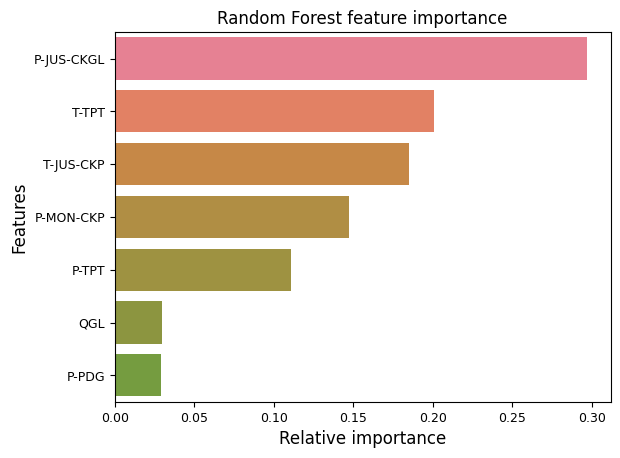

In [17]:
random_palette = sns.color_palette("husl", 20) 

names_classifiers = [("Random Forest",RF_best)]
classifier = names_classifiers[0][1]
name = names_classifiers[0][0]
indices = np.argsort(classifier.feature_importances_)[::-1][:40]
g = sns.barplot(y=train[VARS].columns[indices][:40],x = classifier.feature_importances_[indices][:40] , palette=random_palette, orient='h')
g.set_xlabel("Relative importance",fontsize=12)
g.set_ylabel("Features",fontsize=12)
g.tick_params(labelsize=9)
g.set_title(name + " feature importance")

In [18]:
RF_best

RandomForestClassifier(class_weight='balanced', criterion='entropy',
                       max_depth=12, max_features='log2', min_samples_leaf=50,
                       min_samples_split=100, n_estimators=200, n_jobs=-1,
                       random_state=23)

In [19]:
shap.initjs()

In [20]:
train_sample = train[VARS].sample(n=10000, random_state=32)
train_sample  = train_sample.reset_index(drop=True)

In [21]:
explainer = shap.TreeExplainer(RF_best)
shap_values = explainer.shap_values(train_sample)

In [22]:
train_sample.head(2)

,P-PDG,P-TPT,T-TPT,P-MON-CKP,T-JUS-CKP,P-JUS-CKGL,QGL
0,1.0,0.001413,0.981130,0.117430,0.449165,0.001393,0.0
1,1.0,0.001236,0.975894,0.045796,0.427016,0.001388,0.0


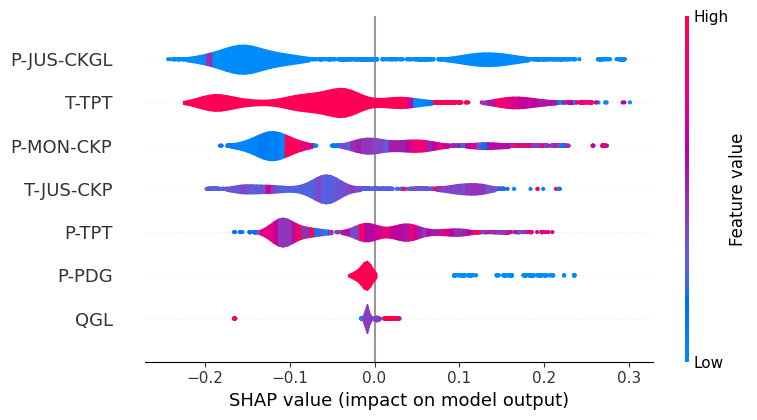

In [23]:
shap.summary_plot(shap_values[:,:,1], train_sample, plot_type="violin", max_display=None, show=False)

### LGBM

In [24]:
filename = './models/LGBM_scale_minmax.pkl'


LGBM_best = joblib.load(filename)

Text(0.5, 1.0, 'LGBM feature importance')

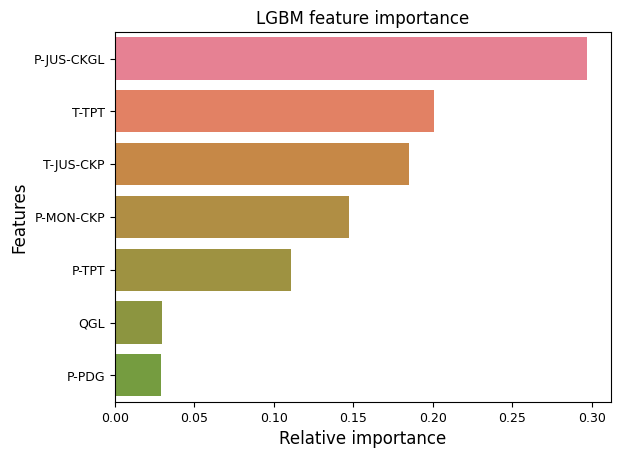

In [25]:
random_palette = sns.color_palette("husl", 20) 

names_classifiers = [("LGBM",LGBM_best)]
name = names_classifiers[0][0]
indices = np.argsort(classifier.feature_importances_)[::-1][:40]
g = sns.barplot(y=test[VARS].columns[indices][:40],x = classifier.feature_importances_[indices][:40] , palette=random_palette, orient='h')
g.set_xlabel("Relative importance",fontsize=12)
g.set_ylabel("Features",fontsize=12)
g.tick_params(labelsize=9)
g.set_title(name + " feature importance")

In [26]:
test_sample = test[VARS].sample(n=100000, random_state=33)
test_sample  = test_sample.reset_index(drop=True)

In [27]:
shap.initjs()
explainer = shap.TreeExplainer(LGBM_best)
shap_values = explainer.shap_values(test_sample)

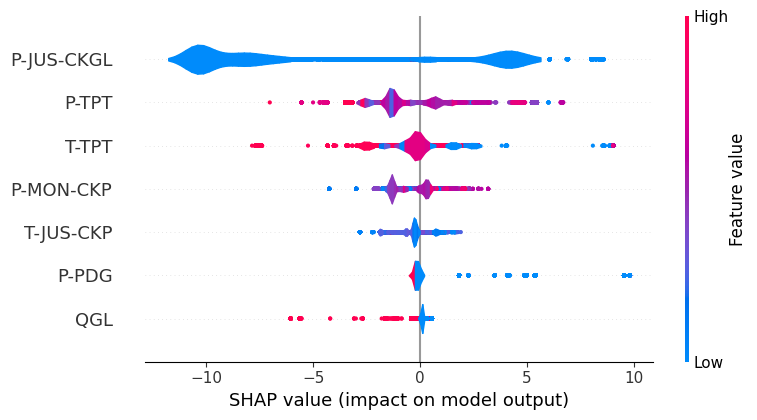

In [28]:
shap.summary_plot(shap_values, test_sample, plot_type="violin", max_display=None, show=False)

### XGBoosting

In [29]:
filename = './models/XGB_scale_minmax.pkl'

XGB_best = joblib.load(filename)

In [30]:
shap.initjs()
explainer = shap.TreeExplainer(XGB_best)
shap_values = explainer.shap_values(test_sample)

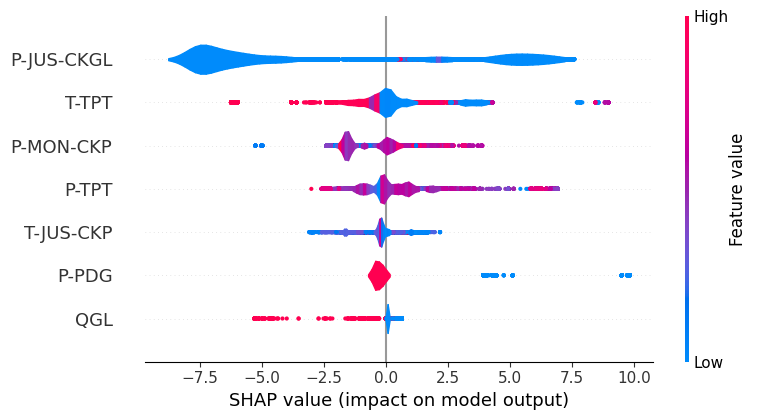

In [31]:
shap.summary_plot(shap_values, test_sample, plot_type="violin", max_display=None, show=False)

In [24]:
y_pred_test = RF_best.predict(test[VARS])

Classification Report: 
               precision    recall  f1-score   support

           0    0.99964   0.99845   0.99904   2209766
           1    0.99696   0.99928   0.99812   1122928

    accuracy                        0.99873   3332694
   macro avg    0.99830   0.99887   0.99858   3332694
weighted avg    0.99874   0.99873   0.99873   3332694

Specificity: 0.998453682426103
Gini:  0.9977385876025704
ROC AUC::  0.9988692938012852


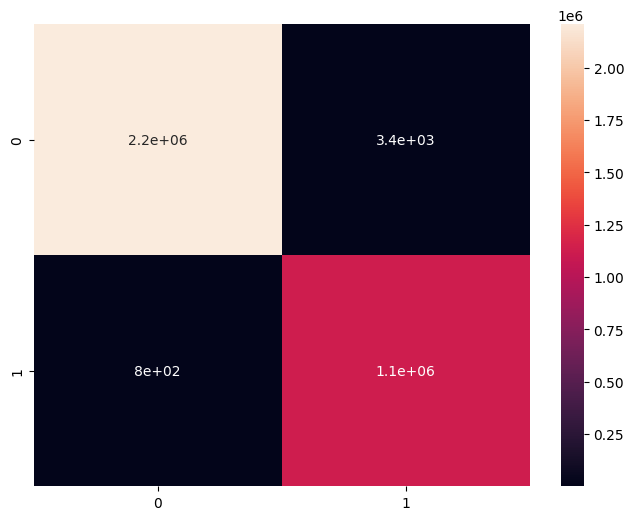

In [25]:
metrics(test.target, y_pred_test)

In [26]:
with open('./models/RF.pkl', 'wb') as file: 
    pickle.dump(RF_best, file)

### LGBM

https://lightgbm.readthedocs.io/en/latest/pythonapi/lightgbm.LGBMClassifier.html

In [29]:
LGBM = LGBMClassifier(random_state=32, n_jobs = -1)

cv = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=1)

LGBM_search_space = {
        'learning_rate' : (0.001, 0.05) , 
        'n_estimators': (100, 200),
        'boosting_type': (['goss']),
        'objective': (['binary']),
        "num_leaves": (16, 32),
        "max_depth": (6, 12), 
        "min_child_samples": (100, 200), 
        "class_weight": (["balanced"])
         }

In [30]:
LGBM_search = GridSearchCV(estimator=LGBM, param_grid=LGBM_search_space, scoring='roc_auc', cv=cv)


start_time = time.time()
LGBM_search.fit(train[VARS], train.target) 
end_time = time.time()
execution_time = end_time - start_time
print(f'Tempo de execução do modelo: {execution_time:.2f} segundos')
print("roc-auc")
print(LGBM_search.best_score_)
LGBM_best = LGBM_search.best_estimator_
print(LGBM_search.best_estimator_)
print(LGBM_search.best_params_)

[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Info] Number of positive: 2096132, number of negative: 4124894
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.343321 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1532
[LightGBM] [Info] Number of data points in the train set: 6221026, number of used features: 7
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[LightGBM] [Warning] Found boosting=goss. For 

In [31]:
y_pred_train = LGBM_best.predict(train[VARS])

[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.


Classification Report: 
               precision    recall  f1-score   support

           0    0.99949   0.99854   0.99901   5156118
           1    0.99712   0.99899   0.99806   2620165

    accuracy                        0.99869   7776283
   macro avg    0.99831   0.99877   0.99854   7776283
weighted avg    0.99869   0.99869   0.99869   7776283

Specificity: 0.9985357200901919
Gini:  0.9975304398883726
ROC AUC::  0.9987652199441863


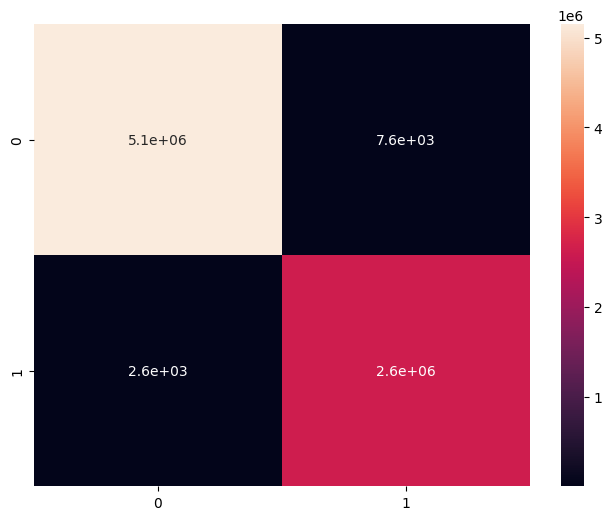

In [32]:
metrics(train.target, y_pred_train)

In [33]:
y_pred_test = LGBM_best.predict(test[VARS])

[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.


Classification Report: 
               precision    recall  f1-score   support

           0    0.99946   0.99852   0.99899   2209766
           1    0.99709   0.99894   0.99801   1122928

    accuracy                        0.99866   3332694
   macro avg    0.99827   0.99873   0.99850   3332694
weighted avg    0.99866   0.99866   0.99866   3332694

Specificity: 0.9985170375505823
Gini:  0.9974537458702608
ROC AUC::  0.9987268729351304


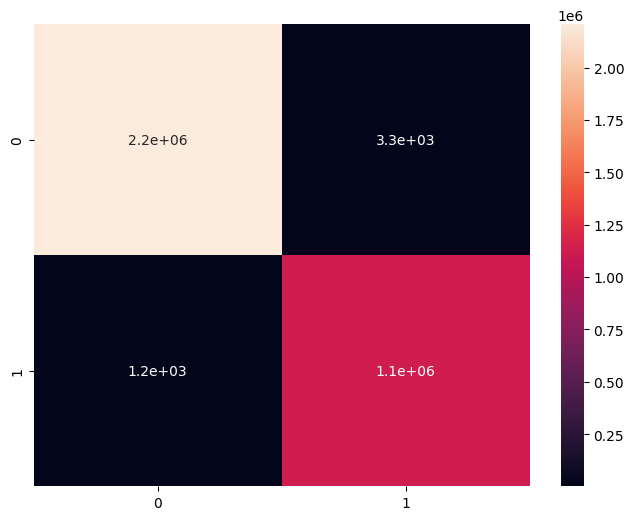

In [34]:
metrics(test.target, y_pred_test)

In [36]:
with open('./models/LGBM.pkl', 'wb') as file: 
    pickle.dump(LGBM_best, file)

### XGBoost

https://xgboost.readthedocs.io/en/stable/parameter.html

In [20]:
XGB = xgb.XGBClassifier(random_state=33, n_jobs=-1)
cv = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=0)


XGB_search_space = {
        "booster": (["gbtree"]),
        'learning_rate' : (0.001, 0.05) , 
        'n_estimators': (50, 200),
        'objective': (["binary:logistic"]),
        "max_depth": (6, 12), 
        "min_child_weight": (150, 200), 
        "reg_alpha": (0.001, 0.5)
         }

In [21]:
XGB_search = GridSearchCV(estimator=XGB, param_grid=XGB_search_space, scoring='roc_auc', cv=cv)


inicio = time.time()
XGB_search.fit(train[VARS], train.target) # callback=on_step will print score after each iteration
fim = time.time()
print("time train")
print(fim - inicio)
print("roc-auc")
print(XGB_search.best_score_)
XGB_best = XGB_search.best_estimator_
print(XGB_search.best_estimator_)
print(XGB_search.best_params_)

time train
1971.0251770019531
roc-auc
0.999996850578336
XGBClassifier(base_score=None, booster='gbtree', callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=12, max_leaves=None,
              min_child_weight=150, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=200, n_jobs=-1,
              num_parallel_tree=None, random_state=33, ...)
{'booster': 'gbtree', 'learning_rate': 0.05, 'max_depth': 12, 'min_child_weight': 150, 'n_estimators': 200, 'objective': 'binary:logistic', 'reg_alpha': 0.001}


In [39]:
1971/60

32.85

In [24]:
y_pred_train = XGB_best.predict(train[VARS])

Classification Report: 
               precision    recall  f1-score   support

           0    0.99937   0.99946   0.99942   5156118
           1    0.99894   0.99876   0.99885   2620165

    accuracy                        0.99923   7776283
   macro avg    0.99916   0.99911   0.99913   7776283
weighted avg    0.99923   0.99923   0.99923   7776283

Specificity: 0.999463937791959
Gini:  0.9982201229940357
ROC AUC::  0.9991100614970179


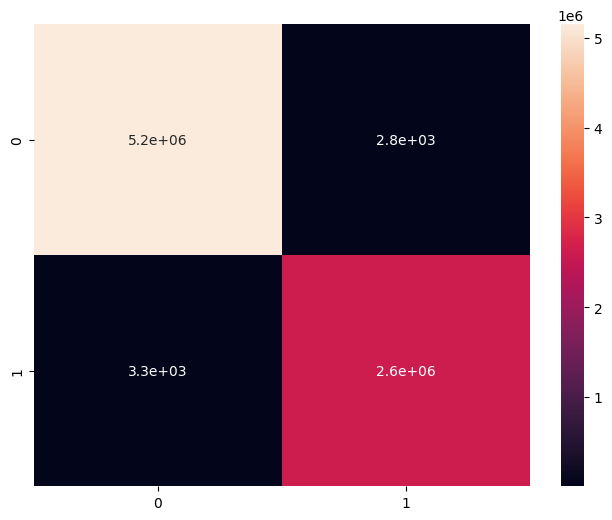

In [27]:
metrics(train.target, y_pred_train)

In [28]:
y_pred_test = XGB_best.predict(test[VARS])

Classification Report: 
               precision    recall  f1-score   support

           0    0.99935   0.99942   0.99939   2209766
           1    0.99887   0.99871   0.99879   1122928

    accuracy                        0.99918   3332694
   macro avg    0.99911   0.99907   0.99909   3332694
weighted avg    0.99918   0.99918   0.99918   3332694

Specificity: 0.9994234683672388
Gini:  0.9981375444255434
ROC AUC::  0.9990687722127717


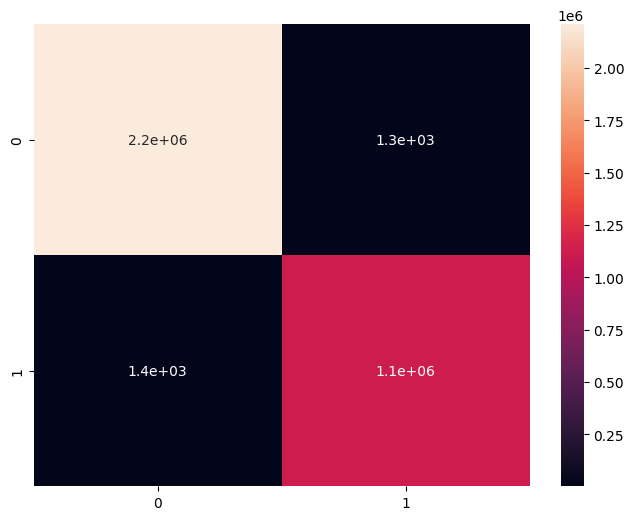

In [29]:
metrics(test.target, y_pred_test)

In [30]:
with open('./models/XGB.pkl', 'wb') as file: 
    pickle.dump(XGB_best, file)

### Logistic Regression

https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html

In [32]:
LR = LogisticRegression(random_state=25)
cv = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=0)

LR_search_space = {
    'penalty': (['l1','l2']),
    'C': (0.01, 1),
    'fit_intercept': ([True, False]), 
    'class_weight': (['balanced'])
}

In [33]:
LR_search = GridSearchCV(estimator=LR, param_grid=LR_search_space, scoring='roc_auc', cv=cv)

inicio = time.time()
LR_search.fit(train[VARS], train.target) # callback=on_step will print score after each iteration
fim = time.time()
print("time train")
print(fim - inicio)
print("Acc")
print(LR_search.best_score_)
LR_best = LR_search.best_estimator_
print(LR_search.best_estimator_)
print(LR_search.best_params_)

c:\Users\User\anaconda3\envs\PHD\Lib\site-packages\sklearn\model_selection\_validation.py:547: FitFailedWarning: 
4 fits failed out of a total of 8.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
4 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\User\anaconda3\envs\PHD\Lib\site-packages\sklearn\model_selection\_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\User\anaconda3\envs\PHD\Lib\site-packages\sklearn\base.py", line 1474, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\User\anaconda3\envs\PHD\Lib\site-packages\sklearn\linear_model\_logistic.py", lin

time train
132.4395079612732
Acc
0.9458071801284771
LogisticRegression(C=1, class_weight='balanced', random_state=25)
{'C': 1, 'class_weight': 'balanced', 'fit_intercept': True, 'penalty': 'l2'}


In [34]:
y_pred_train = LR_best.predict(train[VARS])

Classification Report: 
               precision    recall  f1-score   support

           0    0.92019   0.99031   0.95396   5156118
           1    0.97756   0.83097   0.89832   2620165

    accuracy                        0.93662   7776283
   macro avg    0.94887   0.91064   0.92614   7776283
weighted avg    0.93952   0.93662   0.93521   7776283

Specificity: 0.9903053033309168
Gini:  0.8212720554247734
ROC AUC::  0.9106360277123867


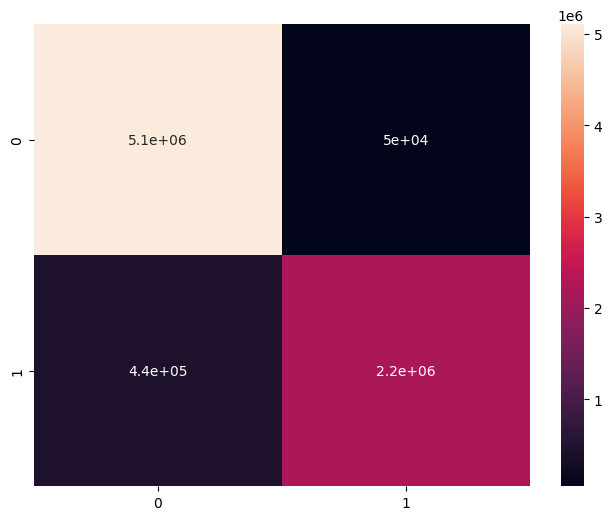

In [35]:
metrics(train.target, y_pred_train)

In [36]:
y_pred_test = LR_best.predict(test[VARS])

Classification Report: 
               precision    recall  f1-score   support

           0    0.91983   0.99023   0.95373   2209766
           1    0.97736   0.83017   0.89777   1122928

    accuracy                        0.93630   3332694
   macro avg    0.94860   0.91020   0.92575   3332694
weighted avg    0.93922   0.93630   0.93488   3332694

Specificity: 0.9902274720490767
Gini:  0.8203991304278864
ROC AUC::  0.9101995652139432


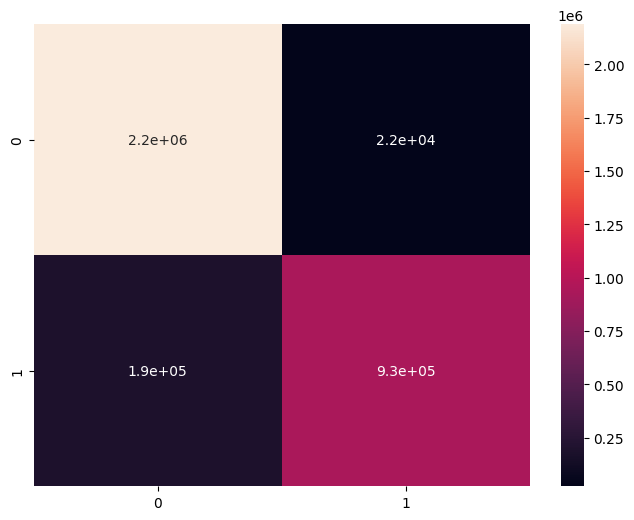

In [37]:
metrics(test.target, y_pred_test)

In [38]:
with open('./models/LR.pkl', 'wb') as file: 
    pickle.dump(LR_best, file)

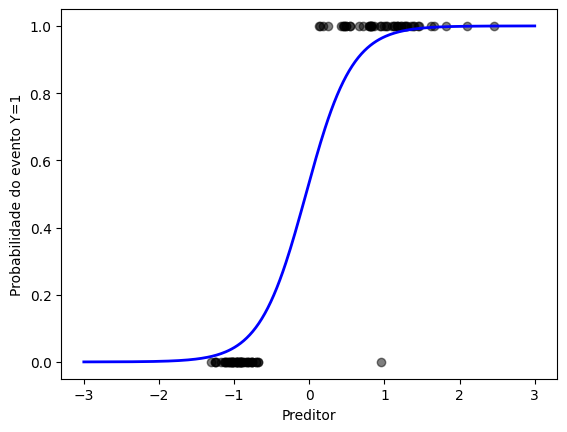

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression

# Gerar dados de exemplo
X, y = make_classification(n_samples=100, n_features=1, n_informative=1, n_redundant=0, n_classes=2, n_clusters_per_class=1, random_state=42)

# Criar e treinar o modelo de regressão logística
model = LogisticRegression()
model.fit(X, y)

# Plotar os pontos de dados
plt.scatter(X, y, color='black',  alpha=0.5)

# Plotar a curva de decisão da regressão logística
X_test = np.linspace(-3, 3, 300).reshape(-1, 1)
y_prob = model.predict_proba(X_test)[:, 1]  # Probabilidade da classe positiva
plt.plot(X_test, y_prob, color='blue', linewidth=2)

# Configurar rótulos e título
plt.xlabel('Preditor')
plt.ylabel('Probabilidade do evento Y=1')
# plt.title('Logistic Regression')

# Exibir o gráfico
plt.show()